<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reframing-Design-Pattern" data-toc-modified-id="Reframing-Design-Pattern-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reframing Design Pattern</a></span></li><li><span><a href="#問題描述" data-toc-modified-id="問題描述-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>問題描述</a></span></li><li><span><a href="#解決方案" data-toc-modified-id="解決方案-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>解決方案</a></span><ul class="toc-item"><li><span><a href="#比較分類的做法和回歸" data-toc-modified-id="比較分類的做法和回歸-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>比較分類的做法和回歸</a></span></li><li><span><a href="#觀察效果" data-toc-modified-id="觀察效果-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>觀察效果</a></span></li><li><span><a href="#增加類別數量" data-toc-modified-id="增加類別數量-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>增加類別數量</a></span></li><li><span><a href="#分類數量、清晰度和變異數" data-toc-modified-id="分類數量、清晰度和變異數-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>分類數量、清晰度和變異數</a></span></li><li><span><a href="#限制輸出範圍" data-toc-modified-id="限制輸出範圍-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>限制輸出範圍</a></span></li><li><span><a href="#代價" data-toc-modified-id="代價-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>代價</a></span></li><li><span><a href="#其他解決方案" data-toc-modified-id="其他解決方案-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>其他解決方案</a></span></li></ul></li></ul></div>

In [1]:
# auto-compeletion faster
%config Completer.use_jedi = False

In [2]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
from os.path import join as PJ
import seaborn as sns
import matplotlib as plt
%matplotlib inline

# Reframing Design Pattern

* 改變問題定義的方式，例如，將職學上屬於回歸的問題定義為分類，反之亦然

# 問題描述

建構任何ML方案之前的第一步是定義問題，其中有幾個關鍵如下

1. 監督式學習，無監督，半監督，自監督?
2. 標籤的定義是什麼、標籤怎麼取得?
3. 可以接受多大的誤差?

E.g. 建立一個ML模型來預測一個地點未來的降雨量，這到底是分類還是回歸?

如果我們要預測降雨量(例如0.3mm)，將它視為時間序列回歸問題應該很合理，然而，當我們開始開發模型時，我們可能會發現

天氣預報不是乍看下那麼簡單，即時特徵完全相同，有時候下0.3mm，有時候下0.5mm

# 解決方案

核心問題 : 降雨是機率性事件，同一組特徵有時候是0.3mm，有時候是0.5mm，因此回歸問題即使給他完全相同的特徵，但一個$y=0.3$, 一個$y=0.5$，他還是只會預測一組數字

我們重定義成多分類問題

 - 模擬離散型機率分佈，y不定義成實數，而定義成多分類的分佈
 
這種做法有相當的好處，降雨量並不是呈現典型的常態分佈，而是[Tweedie分佈](https://zhuanlan.zhihu.com/p/163759573)，在0附近有大量的點

Google Resrarch 有一篇論文就採取這種做法

[MetNet: A Neural Weather Model for Precipitation Forecasting](https://arxiv.org/pdf/2003.12140.pdf)

用512累得類別分佈來預測特定地區的降雨率。

模型可以學到什麼特徵的情況下，分佈會是雙峰的，或是常態的

以下我們以新生兒的體重預測來展示這個做法

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ".key/credential.json"
bq = bigquery.Client()

In [4]:
query = """
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  plurality,
  mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND is_male = true
  AND gestation_weeks = 38
  AND mother_age = 28
  AND mother_race = 1
  AND plurality = 1
  AND RAND() < 0.03
"""

In [5]:
DATA = PJ("data",'007_reframing_005.csv')
SEED = 1

In [6]:
# df = bq.query(query).to_dataframe()
# df.to_csv(DATA, index=False)

df = pd.read_csv(DATA)
print(df.shape)
df.head()

(19730, 6)


,weight_pounds,is_male,gestation_weeks,mother_age,plurality,mother_race
0,8.060100,True,38,28,1,1
1,7.914595,True,38,28,1,1
2,8.664167,True,38,28,1,1
3,6.801261,True,38,28,1,1
4,7.209116,True,38,28,1,1


/Users/YuLong/miniconda3/envs/py_36_tf_21/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'weight_pounds')

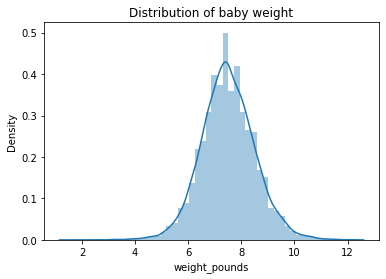

In [7]:
fig = sns.distplot(df[["weight_pounds"]])
fig.set_title("Distribution of baby weight")
fig.set_xlabel("weight_pounds")
# fig.figure.savefig("weight_distrib.png")

In [8]:
#average weight_pounds for this cross section
print(
    np.mean(df.weight_pounds),
    np.std(df.weight_pounds)
)

7.500710216211857 1.012727202815209


## 比較分類的做法和回歸

In [9]:
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model

In [10]:
# prepare inputs
df.is_male = df.is_male.astype(str)
df.plurality = df.plurality.astype(str)
df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)

# create categorical label
def categorical_weight(weight_pounds):
    if weight_pounds < 3.31:
        return 0
    elif weight_pounds >= 3.31 and weight_pounds < 5.5:
        return 1
    elif weight_pounds >= 5.5 and weight_pounds < 8.8:
        return 2
    else:
        return 3

df["weight_category"] = df.weight_pounds.apply(lambda x: categorical_weight(x))

In [11]:
display(
    df.head(),
    df.dtypes
)

,weight_pounds,is_male,gestation_weeks,mother_age,plurality,mother_race,weight_category
0,8.060100,True,38,28,1,1,2
1,7.914595,True,38,28,1,1,2
2,8.664167,True,38,28,1,1,2
3,6.801261,True,38,28,1,1,2
4,7.209116,True,38,28,1,1,2


weight_pounds      float64
is_male             object
gestation_weeks      int64
mother_age           int64
plurality           object
mother_race         object
weight_category      int64
dtype: object

In [12]:
def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']

LABEL_CLS = ['weight_category']
LABEL_REG = ['weight_pounds']

N_TRAIN = int(df.shape[0] * 0.80)

X_train = df[FEATURES][:N_TRAIN]
X_valid = df[FEATURES][N_TRAIN:]

y_train_cls = encode_labels(df[LABEL_CLS][:N_TRAIN])
y_train_reg = df[LABEL_REG][:N_TRAIN]

y_valid_cls = encode_labels(df[LABEL_CLS][N_TRAIN:])
y_valid_reg = df[LABEL_REG][N_TRAIN:]

In [13]:
X_train.columns

Index(['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race'], dtype='object')

In [14]:
print(y_train_cls[0, :])
print(y_train_reg.iloc[0])

[0. 0. 1. 0.]
weight_pounds    8.0601
Name: 0, dtype: float64


In [15]:
# train/validation dataset for classification model
cls_train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train_cls))
cls_valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid_cls))

# train/validation dataset for regression model
reg_train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train_reg.values))
reg_valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid_reg.values))

In [16]:
# # Examine the two datasets. Notice the different label values.
# for data_type in [cls_train_data, reg_train_data]:
#     for dict_slice in data_type.take(1):
#         print("{}\n".format(dict_slice))


In [17]:
# create feature columns to handle categorical variables
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    print(feature, vocab)
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))


plurality ['1']
is_male ['True']
mother_race ['1']


In [18]:
tf.keras.losses

<module 'tensorflow_core.keras.losses' from '/Users/YuLong/miniconda3/envs/py_36_tf_21/lib/python3.6/site-packages/tensorflow_core/python/keras/api/_v2/keras/losses/__init__.py'>

In [19]:
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# build DenseFeatures for the model
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# create hidden layers
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)

# create classification model
cls_output = layers.Dense(4, activation="softmax")(h2)
cls_model = tf.keras.models.Model(inputs=inputs, outputs=cls_output)
cls_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])   


# create regression model
reg_output = layers.Dense(1, activation="relu")(h2)
reg_model = tf.keras.models.Model(inputs=inputs, outputs=reg_output)
reg_model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


In [20]:
print(cls_model.summary())
print(reg_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
mother_race (InputLayer)        [(None,)]            0                                            
______________________________________________________________________________________________

In [21]:
# train the classifcation model
cls_model.fit(cls_train_data.batch(50), epochs=15)

val_loss, val_accuracy = cls_model.evaluate(cls_valid_data.batch(X_valid.shape[0]))
print("Validation accuracy for classifcation model: {}".format(val_accuracy))


Train for 316 steps
Epoch 1/15
316/316 [==============================] - 1s 2ms/step - loss: 0.9187 - accuracy: 0.7926
Epoch 2/15
316/316 [==============================] - 0s 1ms/step - loss: 0.4650 - accuracy: 0.8606
Epoch 3/15
316/316 [==============================] - 0s 1ms/step - loss: 0.4638 - accuracy: 0.8606
Epoch 4/15
316/316 [==============================] - 0s 1ms/step - loss: 0.4621 - accuracy: 0.8606
Epoch 5/15
316/316 [==============================] - 0s 1ms/step - loss: 0.4601 - accuracy: 0.8606
Epoch 6/15
316/316 [==============================] - 0s 1ms/step - loss: 0.4579 - accuracy: 0.8606
Epoch 7/15
316/316 [==============================] - 0s 1ms/step - loss: 0.4560 - accuracy: 0.8606
Epoch 8/15
316/316 [==============================] - 0s 1ms/step - loss: 0.4542 - accuracy: 0.8606
Epoch 9/15
316/316 [==============================] - 0s 1ms/step - loss: 0.4535 - accuracy: 0.8606
Epoch 10/15
316/316 [==============================] - 0s 1ms/step - loss: 0.469

In [22]:

# train the classifcation model
reg_model.fit(reg_train_data.batch(50), epochs=15)

val_loss, val_mse = reg_model.evaluate(reg_valid_data.batch(X_valid.shape[0]))
print("Validation RMSE for regression model: {}".format(val_mse**0.5))

Train for 316 steps
Epoch 1/15
316/316 [==============================] - 1s 2ms/step - loss: 57.4718 - mse: 57.4783
Epoch 2/15
316/316 [==============================] - 0s 1ms/step - loss: 57.4718 - mse: 57.4783
Epoch 3/15
316/316 [==============================] - 0s 1ms/step - loss: 57.4718 - mse: 57.4783
Epoch 4/15
316/316 [==============================] - 0s 1ms/step - loss: 57.4718 - mse: 57.4783
Epoch 5/15
316/316 [==============================] - 0s 1ms/step - loss: 57.4718 - mse: 57.4783
Epoch 6/15
316/316 [==============================] - 0s 1ms/step - loss: 57.4718 - mse: 57.4783
Epoch 7/15
316/316 [==============================] - 0s 1ms/step - loss: 57.4718 - mse: 57.4783
Epoch 8/15
316/316 [==============================] - 0s 1ms/step - loss: 57.4718 - mse: 57.4783
Epoch 9/15
316/316 [==============================] - 0s 1ms/step - loss: 57.4718 - mse: 57.4783
Epoch 10/15
316/316 [==============================] - 0s 1ms/step - loss: 57.4718 - mse: 57.4783
Epoch 11/

In [23]:
preds = reg_model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                             "is_male": tf.convert_to_tensor(["True"]),
                             "mother_age": tf.convert_to_tensor([28]),
                             "mother_race": tf.convert_to_tensor(["1.0"]),
                             "plurality": tf.convert_to_tensor(["Single(1)"])},
                          steps=1).squeeze()
preds

array(0., dtype=float32)

In [24]:
preds = cls_model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                             "is_male": tf.convert_to_tensor(["True"]),
                             "mother_age": tf.convert_to_tensor([28]),
                             "mother_race": tf.convert_to_tensor(["1.0"]),
                             "plurality": tf.convert_to_tensor(["Single(1)"])},
                          steps=1).squeeze()
preds

array([8.2640858e-05, 1.6188629e-03, 9.3036920e-01, 6.7929320e-02],
      dtype=float32)

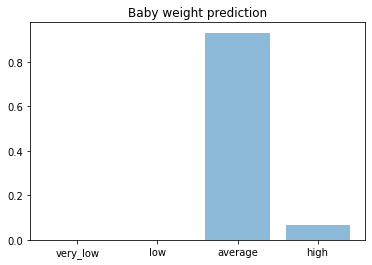

In [25]:
# def categorical_weight(weight_pounds):
#     if weight_pounds < 3.31:
#         return 0
#     elif weight_pounds >= 3.31 and weight_pounds < 5.5:
#         return 1
#     elif weight_pounds >= 5.5 and weight_pounds < 8.8:
#         return 2
#     else:
#         return 3


objects = ('very_low', 'low', 'average', 'high')
y_pos = np.arange(len(objects))
predictions = list(preds)

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Baby weight prediction')

plt.show()

## 觀察效果

你可以看到，透過分類問題的輸出，新生兒體重偏低的機會很大(~0.8)，而回歸則是告訴我們一個數字，6.505，如果你的輸出結果存在一些機率性，這個設計方式就會非常有用，接著我們觀察另一件事

## 增加類別數量

你輸出的類別數量會決定了你的輸出精細度，如果我們需要從預測中獲得更精確的資訊，那麼你就可以這麼做


In [55]:
# create categorical label
MIN = np.min(df.weight_pounds)
MAX = np.max(df.weight_pounds)

NBUCKETS = 8
# NBUCKETS = 50

def categorical_weight(weight_pounds, weight_min, weight_max, nbuckets=10):
    buckets = np.linspace(weight_min, weight_max, nbuckets)
    
    return np.digitize(weight_pounds, buckets) - 1

def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

df["weight_category"] = (
    df.weight_pounds.apply(lambda x: categorical_weight(x, MIN, MAX, NBUCKETS))
)

In [56]:
FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL_COLUMN = ['weight_category']


X_train, y_train = df[FEATURES][:N_TRAIN], encode_labels(df[LABEL_COLUMN][:N_TRAIN])
X_valid, y_valid = df[FEATURES][N_TRAIN:], encode_labels(df[LABEL_COLUMN][N_TRAIN:])


In [57]:
print(y_train[0, :].shape)
print(y_train[0, :])

(8,)
[0. 0. 0. 0. 1. 0. 0. 0.]


In [58]:
train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid))

In [59]:
# create feature columns to handle categorical variables
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

In [60]:
# create Inputs for model
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# build DenseFeatures for the model
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# model
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)
output = layers.Dense(NBUCKETS, activation="softmax")(h2)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [61]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
mother_race (InputLayer)        [(None,)]            0                                            
____________________________________________________________________________________________

In [62]:
model.fit(train_data.batch(50), epochs=30)
# val_loss, val_accuracy = model.evaluate(valid_data.batch(X_valid.shape[0]))
# print("Validation accuracy for classifcation model: {}".format(val_accuracy))


Train for 316 steps
Epoch 1/30
316/316 [==============================] - 1s 3ms/step - loss: 1.4315 - accuracy: 0.4669
Epoch 2/30
316/316 [==============================] - 0s 1ms/step - loss: 1.1154 - accuracy: 0.4413
Epoch 3/30
316/316 [==============================] - 0s 1ms/step - loss: 1.0979 - accuracy: 0.4445
Epoch 4/30
316/316 [==============================] - 0s 1ms/step - loss: 1.0915 - accuracy: 0.4546
Epoch 5/30
316/316 [==============================] - 0s 1ms/step - loss: 1.0889 - accuracy: 0.4597
Epoch 6/30
316/316 [==============================] - 0s 1ms/step - loss: 1.0863 - accuracy: 0.4668
Epoch 7/30
316/316 [==============================] - 0s 1ms/step - loss: 1.0841 - accuracy: 0.4605
Epoch 8/30
316/316 [==============================] - 0s 1ms/step - loss: 1.0821 - accuracy: 0.4574
Epoch 9/30
316/316 [==============================] - 0s 1ms/step - loss: 1.0959 - accuracy: 0.4666
Epoch 10/30
316/316 [==============================] - 0s 1ms/step - loss: 1.074

In [63]:
preds = model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                         "is_male": tf.convert_to_tensor(["True"]),
                         "mother_age": tf.convert_to_tensor([28]),
                         "mother_race": tf.convert_to_tensor(["1.0"]),
                         "plurality": tf.convert_to_tensor(["Single(1)"])},
                      steps=1).squeeze()

In [64]:
preds

array([4.6209158e-07, 1.4254154e-04, 2.0271992e-02, 5.7242584e-01,
       3.9957047e-01, 7.5189867e-03, 6.9629772e-05, 1.5570089e-08],
      dtype=float32)

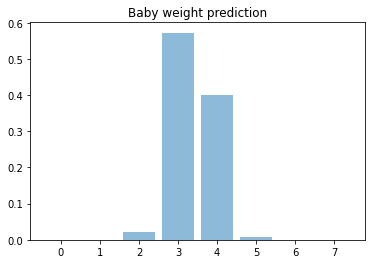

In [65]:
objects = [str(_) for _ in range(NBUCKETS)]
y_pos = np.arange(len(objects))
predictions = list(preds)

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Baby weight prediction')

plt.show()

## 分類數量、清晰度和變異數

* 輸出PDF的精細度意味著回歸任務的精確度
    * 較清晰表示輸出分佈的帶寬較小
    * 反之則是輸出分佈的帶寬較大
    * 如果希望很清晰，那麼還是選用回歸模型

## 限制輸出範圍

* 重新定義問題的其中一個理由是必須限制輸出值的範圍，例如某個回歸問題限定輸出直在[3, 20]之間
    * 什麼都不做的話基本上就是會跑出[3, 20]的界線
    * sigmoid function 可以幫助我們做到這件事情

In [66]:
MIN_Y =  3
MAX_Y = 20
input_size = 10
inputs = keras.layers.Input(shape=(input_size,))
h1 = keras.layers.Dense(20, 'relu')(inputs)
h2 = keras.layers.Dense(1, 'sigmoid')(h1)  # 0-1 range
output = keras.layers.Lambda(lambda y : (y*(MAX_Y-MIN_Y) + MIN_Y))(h2) # scaled
model = keras.Model(inputs, output)

# fit the model
model.compile(optimizer='adam', loss='mse')
batch_size = 2048
for i in range(0, 10):
    x = np.random.rand(batch_size, input_size)
    y = 0.5*(x[:,0] + x[:,1]) * (MAX_Y-MIN_Y) + MIN_Y
    model.fit(x, y)

# verify
min_y = np.finfo(np.float64).max
max_y = np.finfo(np.float64).min
for i in range(0, 10):
    x = np.random.randn(batch_size, input_size)
    y = model.predict(x)
    min_y = min(y.min(), min_y)
    max_y = max(y.max(), max_y)
print('min={} max={}'.format(min_y, max_y))

Train on 2048 samples
2048/2048 [==============================] - 0s 122us/sample - loss: 11.2867
Train on 2048 samples
2048/2048 [==============================] - 0s 28us/sample - loss: 8.5973
Train on 2048 samples
2048/2048 [==============================] - 0s 28us/sample - loss: 5.9522
Train on 2048 samples
2048/2048 [==============================] - 0s 29us/sample - loss: 4.2072
Train on 2048 samples
2048/2048 [==============================] - 0s 29us/sample - loss: 2.7970
Train on 2048 samples
2048/2048 [==============================] - 0s 29us/sample - loss: 1.6922
Train on 2048 samples
2048/2048 [==============================] - 0s 31us/sample - loss: 1.2419
Train on 2048 samples
2048/2048 [==============================] - 0s 32us/sample - loss: 0.8735
Train on 2048 samples
2048/2048 [==============================] - 0s 32us/sample - loss: 0.6660
Train on 2048 samples
2048/2048 [==============================] - 0s 28us/sample - loss: 0.4761
min=3.0013558864593506 max=1

## 代價

* 犧牲精確度
    * 當你變成分類問題，雖然你可以得到一個機率分佈，但你會失去精確值，這一點需要多考量你的任務，是否需要非常精確的數值，還是粗略的數值就可以了



* 標籤偏誤
    標籤可能在資料集中存在某種性質，必須小心地考慮他們，比如以**是否點擊**，作為y的推薦系統，裡面可能藏有使用者誤點，又馬上跳出的行為，這使得你的資料集中有一些 positive label 是不可信的，若無法預估這一點，可能就可以考慮
    * 使用者點擊該素材之後的互動時間
    * 使用者至少觀看該素材一半時間的可能性


## 其他解決方案

* 分位數回歸 - 這是線性回歸的延伸，使得模型不只預測平均值
* 統計建模 - 相似地，透過資料探勘來了解 $y$ 符合什麼分佈，用參數解 + maximum likelihood 來解這個問題(tensorflow_probability)
* 多任務學習 - 特別是基於神經網路的模型，你可以接兩個輸出同時來優化你的模型(持保留意見)